# Simple Redox Tower Simulation

Here, we will attempt to model a very simple redox tower with 3 species and 4 chemicals

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from corrome.sim import (chain_interactions, multinomial_sample,
                         compositional_noise, count_noise,
                         train_count_parameters,
                         train_compositional_parameters)
sns.set_style('white')
%matplotlib inline

Let's first establish a ground truth model.  We can construct this using `chain_interactions`.  We'll need to first define a gradient, and the distributions of microbes along that gradient.  For now, we are assuming that those distributions are all Gaussian with equal variance.

In [2]:
from corrome.sim import chain_interactions
gradient = np.linspace(0, 36, 100)
mu = np.arange(12, 30, 6) 
sigma = np.array([3]*len(mu))
microbial_truth = chain_interactions(gradient, mu, sigma)

Let's spend a little time understanding what exactly we have generated.  



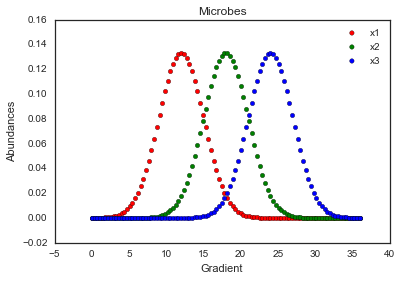

In [3]:
fig, ax = plt.subplots()
ax.scatter(gradient, microbial_truth[:, 0], label='x1', c='r')
ax.scatter(gradient, microbial_truth[:, 1], label='x2', c='g')
ax.scatter(gradient, microbial_truth[:, 2], label='x3', c='b')
ax.set_title('Microbes')
ax.set_ylabel('Abundances')
ax.set_xlabel('Gradient')
ax.legend()

We can see here that each microbe has an optimal abundance along certain portions of the gradient.  We'll want to calculate the correlations between these microbes.  If you correlation the log ratios of the species vs the gradient, you will note that there are nice linear relationships.

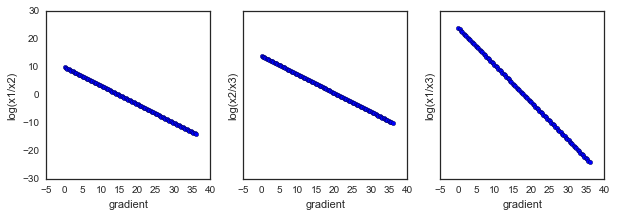

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
ax[0].scatter(gradient, np.log(microbial_truth[:, 0] / microbial_truth[:, 1]))
ax[0].set_ylabel('log(x1/x2)')
ax[0].set_xlabel('gradient')
ax[1].scatter(gradient, np.log(microbial_truth[:, 1] / microbial_truth[:, 2]))
ax[1].set_ylabel('log(x2/x3)')
ax[1].set_xlabel('gradient')
ax[2].scatter(gradient, np.log(microbial_truth[:, 0] / microbial_truth[:, 2]))
ax[2].set_ylabel('log(x1/x3)')
ax[2].set_xlabel('gradient')

This is the basic premise behind a redox tower -- each microbe has a well-defined niche along the gradient.

A real life biological example is a microbial mat.  On top of the mat, the community is dominated by phototrophs that consume sunlight.  This favors energetically demanding reactions, such as photosynthesis.  But the light can only penerate a few millimeters into the mat.  So the deeper layers of the mat are dominated by chemotrophs that utilize less energy favorable reactions, such as sulfur reduction.  These microbes are exchanging molecules with each other, the secreted byproducts of the phototrophs are eventually consumed by the chemotrophs.

We'll simulate the corresponding molecules in next.

In [5]:
gradient = np.linspace(0, 36, 100)
mu = np.arange(10, 30, 5) 
sigma = np.array([3]*len(mu))
molecular_truth = chain_interactions(gradient, mu, sigma)

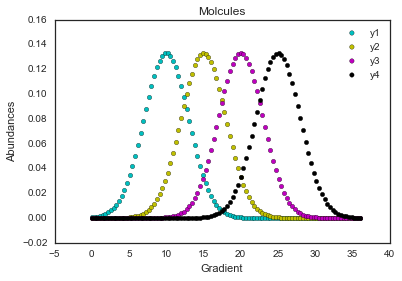

In [6]:
from cycler import cycler
fig, ax = plt.subplots()
ax.scatter(gradient, molecular_truth[:, 0], label='y1', c='c')
ax.scatter(gradient, molecular_truth[:, 1], label='y2', c='y')
ax.scatter(gradient, molecular_truth[:, 2], label='y3', c='m')
ax.scatter(gradient, molecular_truth[:, 3], label='y4', c='k')
ax.set_title('Molcules')
ax.set_ylabel('Abundances')
ax.set_xlabel('Gradient')
ax.legend()

So here, we have the molecule `y1` being inputted into the system, and `y4` being outputted of the system. 
`y2` and `y3` are intermediate molecules - `y2` is an intermediate between `x1` and `x2`, and `y3` is an intermediate between `x2` and `x3`.  Let's plot these together to make this more intuitive.

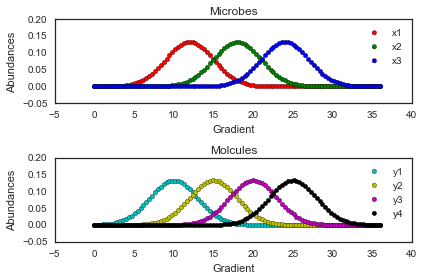

In [7]:

fig, ax = plt.subplots(2)
ax[0].scatter(gradient, microbial_truth[:, 0], label='x1', c='r')
ax[0].scatter(gradient, microbial_truth[:, 1], label='x2', c='g')
ax[0].scatter(gradient, microbial_truth[:, 2], label='x3', c='b')
ax[0].set_title('Microbes')
ax[0].set_ylabel('Abundances')
ax[0].set_xlabel('Gradient')
ax[0].legend()

ax[1].scatter(gradient, molecular_truth[:, 0], label='y1', c='c')
ax[1].scatter(gradient, molecular_truth[:, 1], label='y2', c='y')
ax[1].scatter(gradient, molecular_truth[:, 2], label='y3', c='m')
ax[1].scatter(gradient, molecular_truth[:, 3], label='y4', c='k')
ax[1].set_title('Molcules')
ax[1].set_ylabel('Abundances')
ax[1].set_xlabel('Gradient')
ax[1].legend()
plt.tight_layout()

Now we have our ground truth model - let's now try to simulate the process of sampling from this environment.
We'll simulate the following processes

1. Closure (convert the absolute abundances into proportions).
2. Multiplicative noise (modeling stochastic growth/death processes).  
3. Additive noise (modeling the introduction of contaminates).  
4. Sampling noise (modeling errors from sequencing depth and counting)

# Closure

Since we can rarely observe the entire environment to begin with, we can only infer the proportions.
Given this, we will convert the absolute abundances of the ground truth model into proportions.  We'll 
be using these proportions to generate the counts in the multinomial sampling process.

In [8]:
from skbio.stats.composition import closure
microbial_table = closure(microbial_truth)

# Multiplicative noise

Here we will model the multiplicative noise using an ilr normal distribution.  This will be done using the `compositional_noise` function.  For starters, we will assume that standard deviation is very small, around 0.1.  In addition, we'll assume that the noise sources aren't correlated (i.e. the noise in `x1` doesn't impact `x2`.)

Since we are dealing with probabilities now, the data that we dealing with actually live in the probability simplex $S^3$.  Note that $S^3$ only has two dimensions (i.e. $S^3 \simeq R^2$).  This is why we specify our covariance matrix to be 2x2.

We will also want to control our random seed so that we can have reproducible results.

In [9]:
from corrome.sim import compositional_noise
from numpy.random import RandomState
rng = RandomState(0)
cov = np.eye(2)
m_noise = compositional_noise(cov, nsamp=len(gradient), rng=rng)

We'll want to use the compositional communtative operation in this case. This can be done using the `perturb` operation.  

In [10]:
from skbio.stats.composition import perturb
microbial_table = np.vstack([
    perturb(microbial_table[i, :], m_noise[i, :])
    for i in range(len(gradient))])

We'll perform the same operation on the molecules. Note that the molecules live in $S^4$ so we'll want the covariance to be 3x3.

In [11]:
cov = np.eye(3)
m_noise = compositional_noise(cov, nsamp=len(gradient), rng=rng)
molecular_table = np.vstack([
    perturb(molecular_truth[i, :], m_noise[i, :])
    for i in range(len(gradient))])

Let's plot the microbial abundances together to see what the modified proportions look like.

In [12]:
def prettify_legend(ax):
    # Helper function for making axes pretty
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

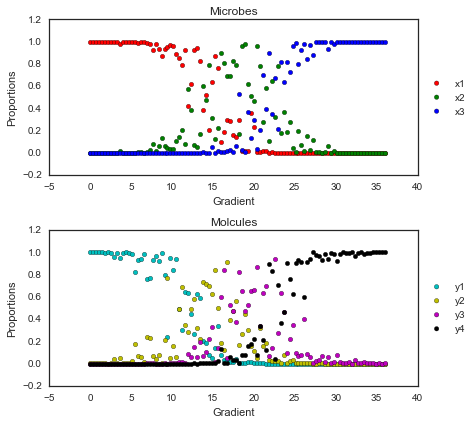

In [13]:
fig, ax = plt.subplots(2, figsize=(6, 6))
ax[0].scatter(gradient, microbial_table[:, 0], label='x1', c='r')
ax[0].scatter(gradient, microbial_table[:, 1], label='x2', c='g')
ax[0].scatter(gradient, microbial_table[:, 2], label='x3', c='b')
ax[0].set_title('Microbes')
ax[0].set_ylabel('Proportions')
ax[0].set_xlabel('Gradient')
ax[0].legend(loc='best')
prettify_legend(ax[0])

ax[1].scatter(gradient, molecular_table[:, 0], label='y1', c='c')
ax[1].scatter(gradient, molecular_table[:, 1], label='y2', c='y')
ax[1].scatter(gradient, molecular_table[:, 2], label='y3', c='m')
ax[1].scatter(gradient, molecular_table[:, 3], label='y4', c='k')
ax[1].set_title('Molcules')
ax[1].set_ylabel('Proportions')
ax[1].set_xlabel('Gradient')
prettify_legend(ax[1])

plt.tight_layout()

Note that we are dealing with proportions, which is why some of the species are approaching 1 at the ends of the gradient.

# Additive noise

Here we will be modeling the contaminants as an exponential urn.  We will introduce 100 contaminants that are exponentially distributed.  Later, we will be drawing samples that on average have 10000 reads.  So we'll want the smallest value to be around 1/10000.

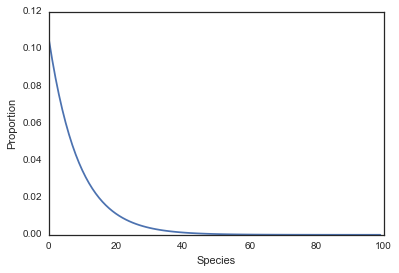

In [14]:
from scipy.stats import expon
x = np.linspace(0, 11, 100)
contaminant_urn = closure(expon.pdf(x))
plt.plot(contaminant_urn)
plt.xlabel('Species')
plt.ylabel('Proportion')

Now we will add these contaminants into our ground truth microbial model.  To do this, we'll directly concatenate these species distributions directly to the exising microbial proportions.

In [15]:
contaminant_urns = np.repeat(np.expand_dims(contaminant_urn, axis=0),
                             microbial_table.shape[0], axis=0)
microbial_table = np.hstack((microbial_table, contaminant_urns))
microbial_table = closure(microbial_table)

Now let's do the same thing with the metabolites.  Given that the metabolite tables are a bit more dense, we'll
make the exponential distribution less steep. There's also typically more metabolites, so we'll have about ten times as many molecules than microbes.

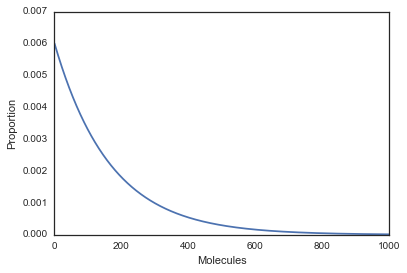

In [16]:
from scipy.stats import expon
x = np.linspace(0, 6, 1000)
contaminant_urn = closure(expon.pdf(x))
plt.plot(contaminant_urn)
plt.xlabel('Molecules')
plt.ylabel('Proportion')

In [17]:
contaminant_urns = np.repeat(np.expand_dims(contaminant_urn, axis=0),
                             molecular_table.shape[0], axis=0)
molecular_table = np.hstack((molecular_table, contaminant_urns))
molecular_table = closure(molecular_table)

# Sampling noise

Now that we have our urns calculated across all of our samples, now we can simulate the process of sampling these urns.

There are two steps to this process - calculating the sequencing depth and counting the species / molecules within an urn.  To simulate the sequencing depth, we'll assume that it follows a Poisson process.  We can then randomly generate the sequencing depths using a Poisson random variable.  Good sequencing depths are typically above 10k reads, so we'll set our Poisson parameter $\lambda=10000$.  Once we have the sequencing depths, we can generate the counts using a multinomial.  All of this can be done using the `multinomial_sample` function. 

In [18]:
microbial_table = multinomial_sample(microbial_table, lam=10000)

Metabolomics typically has a much higher sampling depth.  Here will set $\lambda=100000$ to try to capture this.

In [19]:
molecular_table = multinomial_sample(molecular_table, lam=100000)

# Summary

Let's plot the presence and absence of microbes and molecules to see the how the tables turned out.

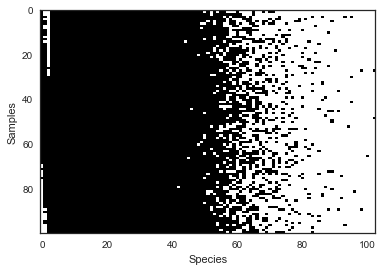

In [20]:
plt.imshow(microbial_table>0, aspect='auto', interpolation='nearest')
plt.xlabel('Species')
plt.ylabel('Samples')

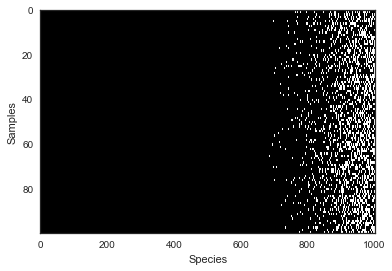

In [21]:
plt.imshow(molecular_table>0, aspect='auto', interpolation='nearest')
plt.xlabel('Species')
plt.ylabel('Samples')

Just for kicks, let's plot the log ratios of the original species that we were interested in.

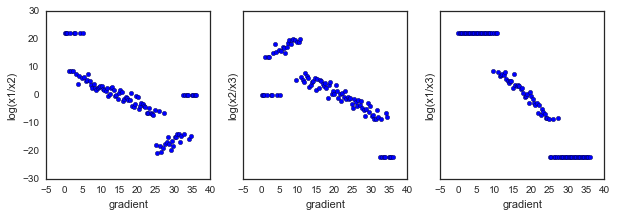

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
ax[0].scatter(gradient, np.log((microbial_table[:, 0]+1e-6) / (microbial_table[:, 1]+1e-6)))
ax[0].set_ylabel('log(x1/x2)')
ax[0].set_xlabel('gradient')
ax[1].scatter(gradient, np.log((microbial_table[:, 1]+1e-6) / (microbial_table[:, 2]+1e-6)))
ax[1].set_ylabel('log(x2/x3)')
ax[1].set_xlabel('gradient')
ax[2].scatter(gradient, np.log((microbial_table[:, 0]+1e-6) / (microbial_table[:, 2]+1e-6)))
ax[2].set_ylabel('log(x1/x3)')
ax[2].set_xlabel('gradient')

Looks like the correlations still can be estimated, but the zeros will definitely be a problem.

# Packaging

We will now package these tables into biom tables for benchmarking

In [23]:
from biom import Table
from biom.util import biom_open

microbial_ids = ["X%d" % i for i in range(microbial_table.shape[1])]
molecular_ids = ["Y%d" % i for i in range(molecular_table.shape[1])]
sample_ids = ["S%d" % i for i in range(molecular_table.shape[0])]

molecular_biom = Table(molecular_table.T, molecular_ids, sample_ids)
microbial_biom = Table(microbial_table.T, microbial_ids, sample_ids)

with biom_open('../data/simple-redox-microbial.biom', 'w') as f:  
    microbial_biom.to_hdf5(f, "microbes")

with biom_open('../data/simple-redox-molecules.biom', 'w') as f:  
    molecular_biom.to_hdf5(f, "molecules")

array([[49865,    95,     0, ...,     0,     0,     0],
       [50033,    26,     0, ...,     2,     1,     0],
       [49898,    86,     0, ...,     3,     1,     1],
       ..., 
       [    0,     0,    83, ...,     0,     0,     1],
       [    0,     0,    22, ...,     1,     0,     1],
       [    0,     0,    70, ...,     0,     1,     0]])